<a href="https://colab.research.google.com/github/JASCRAJ/Sketch-literature/blob/main/Sam_for_paintings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
using_colab = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    #!mkdir images
    #!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    #!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.3.0+cu121
Torchvision version: 0.18.0+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-txuldhed
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-txuldhed
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=d6f19ac2f70d2e7a093d6472eed8f7b758bf3c1df8c364730c4c8b37556a3c95
  Stored in directory: /tmp/pip-ephem-wheel-cache-ifphz3xc/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [ ]:
#!wget -P /content/drive/MyDrive/Seg_output https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Define paths and device
sam_checkpoint = "/content/drive/MyDrive/Seg_output/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cpu"#"cuda"

# Initialize SAM model and mask generator
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator_3 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=8,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=500,
)

In [ ]:
# Load image (replace 'image_path' with the path to your image)
image_path = "/content/Naked Male with Arms Raised.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plt.imshow
masks3 = mask_generator_3.generate(image)

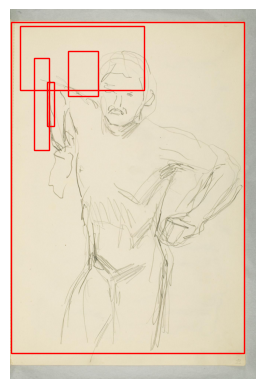

In [ ]:
# Initialize CSV file
csv_file_path = "bounding_boxes.csv"
with open(csv_file_path, 'w', newline='') as csvfile:
    fieldnames = ['x1', 'y1', 'x2', 'y2']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    # Draw bounding boxes on the image and save coordinates to CSV
    fig, ax = plt.subplots()
    ax.imshow(image_rgb)

    for mask in masks3:
        bbox = mask['bbox']
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        writer.writerow({'x1': bbox[0], 'y1': bbox[1], 'x2': bbox[2], 'y2': bbox[3]})

    plt.axis('off')
    plt.savefig("image_with_bounding_boxes.png", bbox_inches='tight', pad_inches=0)
    plt.show()

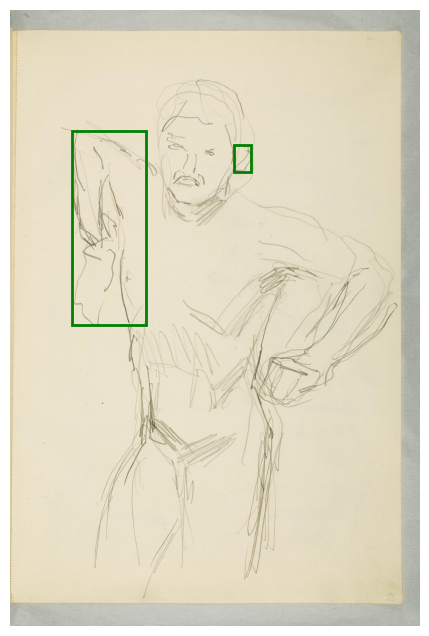

CSV file './Naked Male with Arms Raised_bboxinfo.csv' has been updated with non-overlapping mask information.


In [ ]:
import csv
import os

# Define the directory where the file will be saved
output_directory = "./"  # Change this to your desired directory

# Define the file name based on the original image file name
image_filename = os.path.basename(image_path)
csv_file_name = os.path.splitext(image_filename)[0] + "_bboxinfo.csv"
csv_file_path = os.path.join(output_directory, csv_file_name)

# Check if the CSV file exists, if not, create it
if not os.path.exists(csv_file_path):
    with open(csv_file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Mask Index', 'Area', 'Bounding Box'])

# Filter masks based on area within the specified range
filtered_masks = [mask for mask in masks3 if 1000 <= mask['area'] <= 100000]

# Sort filtered masks based on area in descending order
sorted_masks = sorted(filtered_masks, key=lambda x: x['area'], reverse=True)

# Get bounding boxes of the first 10 non-overlapping masks or all masks if there are fewer than 10
num_masks_to_print = 10
non_overlapping_bboxes = []
with open(csv_file_path, 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for mask in sorted_masks:
        bbox = mask['bbox']
        area = mask['area']

        # Check for overlap with existing bounding boxes
        is_overlapping = False
        for existing_bbox in non_overlapping_bboxes:
            if (bbox[0] < existing_bbox[0] + existing_bbox[2] and
                bbox[0] + bbox[2] > existing_bbox[0] and
                bbox[1] < existing_bbox[1] + existing_bbox[3] and
                bbox[1] + bbox[3] > existing_bbox[1]):
                is_overlapping = True
                break

        # If not overlapping, add the bounding box and write to CSV
        if not is_overlapping:
            non_overlapping_bboxes.append(bbox)
            writer.writerow([len(non_overlapping_bboxes), area, bbox])
            if len(non_overlapping_bboxes) >= num_masks_to_print:
                break

# Display bounding boxes on the input image
plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
ax = plt.gca()
for bbox in non_overlapping_bboxes:
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], edgecolor='g', linewidth=2, facecolor='none')
    ax.add_patch(rect)

plt.axis('off')
plt.show()

print(f"CSV file '{csv_file_path}' has been updated with non-overlapping mask information.")


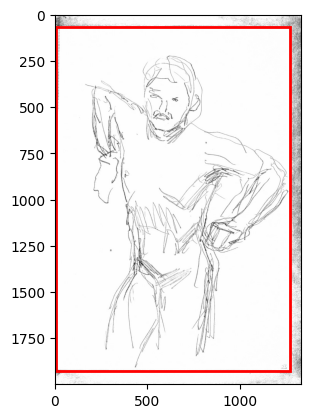

In [ ]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

def parse_path(path_data):
    commands = ['M', 'Q', 'C', 'A', 'L', 'Z']
    current_command = None
    current_coords = []
    paths = []
    for token in path_data.split():
        if token in commands:
            if current_command:
                paths.append((current_command, current_coords))
                current_coords = []
            current_command = token
        else:
            current_coords.append(float(token))
    paths.append((current_command, current_coords))
    return paths

def is_point_inside_bbox(point, bbox):
    x, y = point
    return bbox[0] <= x <= bbox[0] + bbox[2] and bbox[1] <= y <= bbox[1] + bbox[3]

def point_on_ellipse(center, radius_x, radius_y, angle_degrees):
    angle_radians = np.radians(angle_degrees)
    x = center[0] + radius_x * np.cos(angle_radians)
    y = center[1] + radius_y * np.sin(angle_radians)
    return (x, y)

def extract_paths(svg_file):
    paths = []
    tree = ET.parse(svg_file)
    root = tree.getroot()
    width = root.attrib.get('width')
    height = root.attrib.get('height')
    for elem in root.iter():
        if '}' in elem.tag:
            tag = elem.tag.split('}')[-1]
        else:
            tag = elem.tag
        if tag == 'path':
            path_data = elem.attrib['d']
            fill_color = elem.attrib.get('fill', 'none')
            paths.append({'d': path_data, 'fill': fill_color})
    return paths, width, height

def paths_within_bbox(paths, bbox):
    # Filter paths falling within the bounding box
    paths_within_box = []
    for path in paths:
        path_coords = parse_path(path['d'])
        for command, coords in path_coords:
            if command == 'M':
                x, y = coords[0], coords[1]
                if is_point_inside_bbox((x, y), bbox):
                    paths_within_box.append(path)
                    break
            elif command == 'L':
                for i in range(0, len(coords), 2):
                    x = coords[i]
                    y = coords[i + 1]
                    if is_point_inside_bbox((x, y), bbox):
                        paths_within_box.append(path)
                        break
            elif command == 'Q':
                for i in range(0, len(coords), 4):
                    x1, y1, x, y = coords[i:i+4]
                    if is_point_inside_bbox((x1, y1), bbox) or is_point_inside_bbox((x, y), bbox):
                        paths_within_box.append(path)
                        break
            elif command == 'C':
                for i in range(0, len(coords), 6):
                    x1, y1, x2, y2, x, y = coords[i:i+6]
                    if is_point_inside_bbox((x1, y1), bbox) or is_point_inside_bbox((x2, y2), bbox) or is_point_inside_bbox((x, y), bbox):
                        paths_within_box.append(path)
                        break
            elif command == 'A':
                # Handling elliptical arcs
                rx, ry, x_axis_rotation, large_arc_flag, sweep_flag, x, y = coords[-7:]
                if is_point_inside_bbox((x, y), bbox):
                    paths_within_box.append(path)
                    break
                else:
                    # Calculate the points on the elliptical arc and check if any falls inside the bounding box
                    start_angle = np.radians(x_axis_rotation)
                    end_angle = start_angle + np.radians(large_arc_flag * 180)
                    step = 0.1  # Step for angle increment, can adjust based on precision needed
                    for angle in np.arange(start_angle, end_angle, step):
                        point = point_on_ellipse((coords[0], coords[1]), rx, ry, np.degrees(angle))
                        if is_point_inside_bbox(point, bbox):
                            paths_within_box.append(path)
                            break
    return paths_within_box

def write_svg_file(output_path, paths, width, height):
    svg = ET.Element('svg', xmlns="http://www.w3.org/2000/svg", width=width, height=height)
    for path in paths:
        path_element = ET.SubElement(svg, 'path', d=path['d'])
        if path['fill'] != 'none':
            path_element.set('fill', path['fill'])
    tree = ET.ElementTree(svg)
    tree.write(output_path)

def display_bounding_box(image_path, bbox):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.show()

# Example usage
def main():
    # SVG file path
    svg_file_path = "/content/NakedMalewithArmsRaised_line_accumulated_clusters_2_228.svg"
    # Bounding box coordinates (x1, y1, width, height)
    bounding_box = (6, 68, 1266, 1858)
    # Display bounding box on input image
    display_bounding_box("/content/Naked Male with Arms Raised.jpg", bounding_box)

    # Extract paths from SVG file
    paths, width, height = extract_paths(svg_file_path)

    # Filter paths falling within the bounding box
    paths_within_box = paths_within_bbox(paths, bounding_box)

    # Write filtered paths to a new SVG file
    output_svg_path = "output_bbox.svg"
    write_svg_file(output_svg_path, paths_within_box, width, height)

if __name__ == "__main__":
    main()


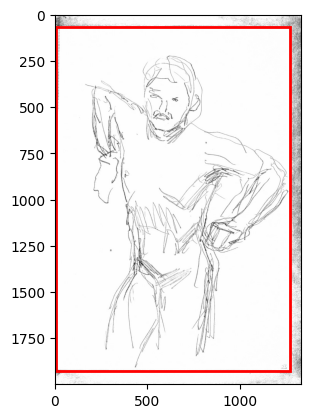

In [ ]:
import xml.etree.ElementTree as ET
import numpy as np

def parse_path(path_data):
    commands = ['M', 'Q', 'C', 'A', 'L', 'Z']
    current_command = None
    current_coords = []
    paths = []
    for token in path_data.split():
        if token in commands:
            if current_command:
                paths.append((current_command, current_coords))
                current_coords = []
            current_command = token
        else:
            current_coords.append(float(token))
    paths.append((current_command, current_coords))
    return paths


def is_point_inside_bbox(point, bbox):
    x, y = point
    return bbox[0] <= x <= bbox[0] + bbox[2] and bbox[1] <= y <= bbox[1] + bbox[3]

def point_on_ellipse(center, radius_x, radius_y, angle_degrees):
    angle_radians = np.radians(angle_degrees)
    x = center[0] + radius_x * np.cos(angle_radians)
    y = center[1] + radius_y * np.sin(angle_radians)
    return (x, y)

def extract_paths(svg_file):
    paths = []
    tree = ET.parse(svg_file)
    root = tree.getroot()
    for elem in root.iter():
        if '}' in elem.tag:
            tag = elem.tag.split('}')[-1]
        else:
            tag = elem.tag
        if tag == 'path':
            path_data = elem.attrib['d']
            fill_color = elem.attrib.get('fill', 'none')
            paths.append({'d': path_data, 'fill': fill_color})
    return paths

def paths_within_bbox(paths, bbox):
    # Filter paths falling within the bounding box
    paths_within_box = []
    for path in paths:
        path_coords = parse_path(path['d'])
        for command, coords in path_coords:
            if command == 'M':
                x, y = coords[0], coords[1]
                if is_point_inside_bbox((x, y), bbox):
                    paths_within_box.append(path)
                    break
            elif command == 'L':
                for i in range(0, len(coords), 2):
                    x = coords[i]
                    y = coords[i + 1]
                    if is_point_inside_bbox((x, y), bbox):
                        paths_within_box.append(path)
                        break
            elif command == 'Q':
                for i in range(0, len(coords), 4):
                    x1, y1, x, y = coords[i:i+4]
                    if is_point_inside_bbox((x1, y1), bbox) or is_point_inside_bbox((x, y), bbox):
                        paths_within_box.append(path)
                        break
            elif command == 'C':
                for i in range(0, len(coords), 6):
                    x1, y1, x2, y2, x, y = coords[i:i+6]
                    if is_point_inside_bbox((x1, y1), bbox) or is_point_inside_bbox((x2, y2), bbox) or is_point_inside_bbox((x, y), bbox):
                        paths_within_box.append(path)
                        break
            elif command == 'A':
                # Handling elliptical arcs
                rx, ry, x_axis_rotation, large_arc_flag, sweep_flag, x, y = coords[-7:]
                if is_point_inside_bbox((x, y), bbox):
                    paths_within_box.append(path)
                    break
                else:
                    # Calculate the points on the elliptical arc and check if any falls inside the bounding box
                    start_angle = np.radians(x_axis_rotation)
                    end_angle = start_angle + np.radians(large_arc_flag * 180)
                    step = 0.1  # Step for angle increment, can adjust based on precision needed
                    for angle in np.arange(start_angle, end_angle, step):
                        point = point_on_ellipse((coords[0], coords[1]), rx, ry, np.degrees(angle))
                        if is_point_inside_bbox(point, bbox):
                            paths_within_box.append(path)
                            break
    return paths_within_box
def display_bounding_box(image_path, bbox):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.show()

# Example usage
def main():
    # SVG file path
    svg_file_path = "/content/NakedMalewithArmsRaised_line_accumulated_clusters_2_228.svg"
    # Bounding box coordinates (x1, y1, width, height)
    bounding_box = (6, 68, 1266, 1858)
    # Display bounding box on input image
    display_bounding_box("/content/Naked Male with Arms Raised.jpg", bounding_box)

    # Extract paths from SVG file
    paths = extract_paths(svg_file_path)

    # Filter paths falling within the bounding box
    paths_within_box = paths_within_bbox(paths, bounding_box)

    # Write filtered paths to a new SVG file
    output_svg_path = "output_bbox.svg"
    write_svg_file(output_svg_path, paths_within_box)

if __name__ == "__main__":
    main()


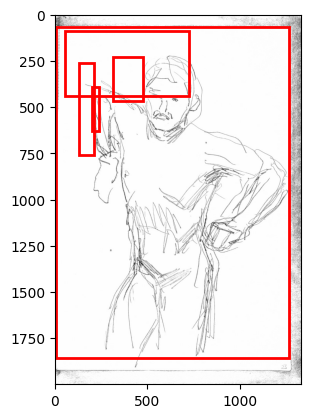

In [ ]:
import xml.etree.ElementTree as ET
import numpy as np
import csv
def parse_path(path_data):
    commands = ['M', 'Q', 'C', 'A', 'L', 'Z']
    current_command = None
    current_coords = []
    paths = []
    for token in path_data.split():
        if token in commands:
            if current_command:
                paths.append((current_command, current_coords))
                current_coords = []
            current_command = token
        else:
            current_coords.append(float(token))
    paths.append((current_command, current_coords))
    return paths


def is_point_inside_bbox(point, bbox):
    x, y = point
    return bbox[0] <= x <= bbox[0] + bbox[2] and bbox[1] <= y <= bbox[1] + bbox[3]

def point_on_ellipse(center, radius_x, radius_y, angle_degrees):
    angle_radians = np.radians(angle_degrees)
    x = center[0] + radius_x * np.cos(angle_radians)
    y = center[1] + radius_y * np.sin(angle_radians)
    return (x, y)

def extract_paths(svg_file):
    paths = []
    tree = ET.parse(svg_file)
    root = tree.getroot()
    for elem in root.iter():
        if '}' in elem.tag:
            tag = elem.tag.split('}')[-1]
        else:
            tag = elem.tag
        if tag == 'path':
            path_data = elem.attrib['d']
            fill_color = elem.attrib.get('fill', 'none')
            paths.append({'d': path_data, 'fill': fill_color})
    return paths

def paths_within_bbox(paths, bbox):
    # Filter paths falling within the bounding box
    paths_within_box = []
    for path in paths:
        path_coords = parse_path(path['d'])
        for command, coords in path_coords:
            if command == 'M':
                x, y = coords[0], coords[1]
                if is_point_inside_bbox((x, y), bbox):
                    paths_within_box.append(path)
                    break
            elif command == 'L':
                for i in range(0, len(coords), 2):
                    x = coords[i]
                    y = coords[i + 1]
                    if is_point_inside_bbox((x, y), bbox):
                        paths_within_box.append(path)
                        break
            elif command == 'Q':
                for i in range(0, len(coords), 4):
                    x1, y1, x, y = coords[i:i+4]
                    if is_point_inside_bbox((x1, y1), bbox) or is_point_inside_bbox((x, y), bbox):
                        paths_within_box.append(path)
                        break
            elif command == 'C':
                for i in range(0, len(coords), 6):
                    x1, y1, x2, y2, x, y = coords[i:i+6]
                    if is_point_inside_bbox((x1, y1), bbox) or is_point_inside_bbox((x2, y2), bbox) or is_point_inside_bbox((x, y), bbox):
                        paths_within_box.append(path)
                        break
            elif command == 'A':
                # Handling elliptical arcs
                rx, ry, x_axis_rotation, large_arc_flag, sweep_flag, x, y = coords[-7:]
                if is_point_inside_bbox((x, y), bbox):
                    paths_within_box.append(path)
                    break
                else:
                    # Calculate the points on the elliptical arc and check if any falls inside the bounding box
                    start_angle = np.radians(x_axis_rotation)
                    end_angle = start_angle + np.radians(large_arc_flag * 180)
                    step = 0.1  # Step for angle increment, can adjust based on precision needed
                    for angle in np.arange(start_angle, end_angle, step):
                        point = point_on_ellipse((coords[0], coords[1]), rx, ry, np.degrees(angle))
                        if is_point_inside_bbox(point, bbox):
                            paths_within_box.append(path)
                            break
    return paths_within_box

import csv

def read_bounding_boxes(csv_file_path):
    bounding_boxes = []
    with open(csv_file_path, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip the header row
        for row in reader:
            x1, y1, x2, y2 = map(int, row)
            width = x2 - x1
            height = y2 - y1
            bounding_boxes.append((x1, y1, width, height))
    return bounding_boxes


def display_bounding_boxes(image_path, bounding_boxes):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for bbox in bounding_boxes:
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

def main():
    # Paths
    svg_file_path = "/content/NakedMalewithArmsRaised_line_accumulated_clusters_2_228.svg"
    image_path = "/content/Naked Male with Arms Raised.jpg"
    csv_file_path = "bounding_boxes.csv"

    # Read bounding boxes from CSV
    bounding_boxes = read_bounding_boxes(csv_file_path)

    # Display all bounding boxes on the input image
    display_bounding_boxes(image_path, bounding_boxes)

    # Extract paths from SVG file
    paths = extract_paths(svg_file_path)

    for i, bbox in enumerate(bounding_boxes):
        # Filter paths falling within the current bounding box
        paths_within_box = paths_within_bbox(paths, bbox)

        # Write filtered paths to a new SVG file
        output_svg_path = f"output_bbox_{i}.svg"
        write_svg_file(output_svg_path, paths_within_box)

if __name__ == "__main__":
    main()
